# Python Project: Deep Learning for Object Recognition

In [1]:
# Loading Training and Test folders from Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
# Importing required modules.
from __future__ import print_function, division
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import cv2 as cv

cudnn.benchmark = True
plt.ion()  

## Splitting Data into Training and Validation Sets

The Training Set folder contains 2 subfolders for each class in this classification problem. Each subfolder contains 1500 images, totalling 3000 images.

70% of the images in this folder will be used to Train the model, whilst the remaining 30% will be used to Validate the model to protect against overfitting.

In [2]:
!pip install split-folders
import splitfolders

# The Training Set will be split in the ratio 70% Training and 30% Validation.
input_folder = '/content/drive/MyDrive/Training_Data'
splitfolders.ratio(input_folder, output="output",
    seed=1337, ratio=(.7, .3), group_prefix=None, move=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3000 files [00:35, 85.19 files/s] 


## Data Standardisation & Augmentation
The following transforms will be applied to all images in either set:
* Cropping
* Image Flip
* Tensor Conversion
* Normalisation

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0, contrast=1, saturation=1, hue=0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


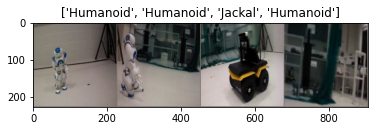

In [5]:
# Displaying some of the images after the tranformations have been applied.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to allow for plots to update.


# Get a batch of training data & make a grid from batch.
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            y_loss[phase].append(epoch_loss)
            y_err[phase].append(epoch_acc)
            if phase == 'val':
               draw_curve(epoch)
 
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

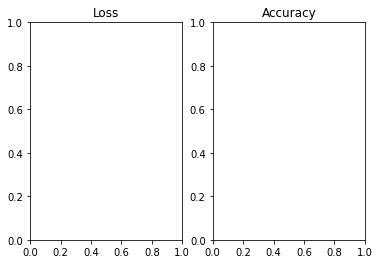

In [50]:
# Setting up Axes to Plot Training & Validation Loss/Accuracy

y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []

x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="Loss")
ax1 = fig.add_subplot(122, title="Accuracy")


def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
        
    fig.savefig(os.path.join('/content/drive/MyDrive', 'Plots.jpg'))


## Transfer Learning

In [10]:
# Finetuning Pre-trained Model

model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features

model_ft.classifier[6] = nn.Linear(num_ftrs, 2) # Size of output set to number 
                                                # of classes

model_ft = model_ft.to(device)

# Initialising Optimizer, Loss Function and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [13]:
# Training & Validating the model based on parameters set.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0711 Acc: 0.9710
val Loss: 0.0002 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.0261 Acc: 0.9890
val Loss: 0.0000 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.0905 Acc: 0.9605
val Loss: 0.0006 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0476 Acc: 0.9805
val Loss: 0.0007 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0446 Acc: 0.9800
val Loss: 0.0000 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0286 Acc: 0.9857
val Loss: 0.0000 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0238 Acc: 0.9905
val Loss: 0.0000 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0178 Acc: 0.9910
val Loss: 0.0000 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0117 Acc: 0.9948
val Loss: 0.0000 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0200 Acc: 0.9910
val Loss: 0.0000 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0146 Acc: 0.9948
val Loss: 0.0000 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0125 Acc: 0.9952
val Loss: 0.0000 Acc: 1.0000

Ep

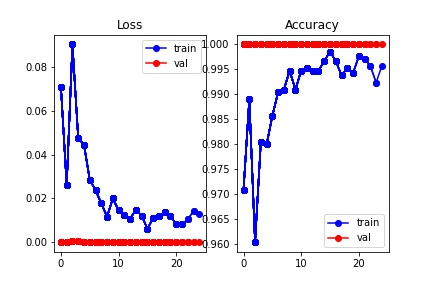

In [58]:
# Visualising Accuracy and Loss over the number of Epochs.
acc_loss = cv.imread('/content/drive/MyDrive/Plots.jpg')
cv2_imshow(acc_loss)

## Testing the Model

In [27]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Test_Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []

  for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.no_grad():
        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds)
        real_values.extend(labels)

  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [47]:
y_pred, y_test = get_predictions(model_ft, dataloaders['test'])

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [40]:
print(classification_report(y_test,y_pred,target_names=class_names))

              precision    recall  f1-score   support

    Humanoid       1.00      1.00      1.00         5
      Jackal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [41]:
def show_predictions(model, class_names,n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs,labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(n_images//2,2,images_handeled)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_handeled == n_images:
          return 

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


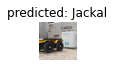

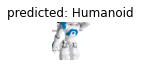

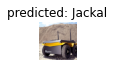

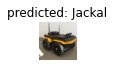

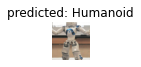

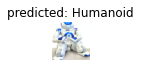

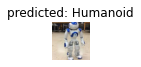

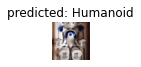

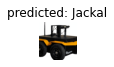

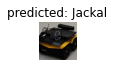

In [42]:
show_predictions(model_ft,class_names,n_images=10)

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30,ha='right')
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class');

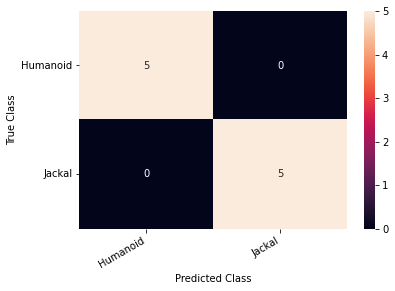

In [44]:
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm,index=class_names,columns=class_names)
show_confusion_matrix(df_cm)